### pca analysis (incubation data)
#### last modified: 7 nov 2025 (ry)

- refer to pca_field_RN.ipynb 

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
## [RUN] functions 

def prepare_df_rank(df, rank:str):
    '''takes in df_field containing all observations (91232), 
    and prepares a dataframe containing 32 rows (samples), and 
    col according to taxonomic rank
    '''
    df_rank = (df.groupby(['sample', rank, 'Lake', 'Edge', 'Depth', 'SampleType', 'SamplingDay', 'Temp', 'SamplingTimepoint'], as_index=False)['Abundance'].sum())
    df_rank_wide = df_rank.pivot_table(
        index=['sample', 'Lake', 'Edge', 'Depth', 'SampleType', 'SamplingDay', 'Temp', 'SamplingTimepoint'],  
        columns=rank,
        values='Abundance',
        fill_value=0  # fill missing abundance w/ 0
        ).reset_index()
    df_rank_wide.columns.name = None
    return df_rank_wide


def run_pca(df_taxa):
    '''takes in df output of prepare_df_rank and runs PCA analysis, 
    returns (a) fracvar, (b) pcs, (c) eigenvectors
    
    note that pca is run on a {m variable x n observations} matrix, where n = 32 (samples), and 
        - m = 100 for phylum 
        - m = 246 for class
        - m = 600 for order 
    
    there are 32 modes of variances (technically m modes, but python outputs min(m,n))
    each pc contains m elements, represents "taxa space"
    each eigenvector contains 32 elements, represents variations across samples 
    '''
    df_cols = df_taxa.columns.difference(['sample', 'Lake', 'Edge', 'Depth', 'SampleType', 'SamplingDay', 'Temp', 'SamplingTimepoint']) # remove unnecessary cols for pca 
    X = df_taxa[df_cols].to_numpy() # shape: 32, m
    pca = PCA()                               
    PCs = pca.fit_transform(X)                                  
    eigvecs = pca.components_                       
    fracVar = pca.explained_variance_ratio_ 
    return fracVar, PCs, eigvecs

def run_pca_log(df_taxa, threshold = 0.35):
    '''similar to run_pca, but with additional preprocessing 
    1. keep only the relevant taxa (col) with >0 abudance in at least X% of samples 
    2. add pseudocount to zero values 
    3. transform data to a centered log-ratio (log, then subtract by sample mean)
        * idea here is to reflect how much more abundant a taxon is compared to the average of that sample
    4. standardize the data 
    '''
    # remove metadata from the df 
    meta_cols = ['sample', 'Lake', 'Edge', 'Depth', 'SampleType', 'SamplingDay', 'Temp', 'SamplingTimepoint']  
    taxa_cols = df_taxa.columns.difference(meta_cols)
    X = df_taxa[taxa_cols].copy()        

    # keep taxa (col) that are found in at least 35% of samples  
    min_prev = max(1, int(np.ceil(threshold * X.shape[0])))       
    keep = (X > 0).sum(axis=0) >= min_prev
    X = X.loc[:, keep]

    # add pseudocount (for log later)
    pseudo = 1e-6
    X_pc = X + pseudo

    # centered log-ratio: log the data then subtract by sample mean (row)
    logX = np.log(X_pc)
    clr = logX.sub(logX.mean(axis=1), axis=0)  

    # standardize the data  
    scaler = StandardScaler(with_mean=True, with_std=True)
    clr_z = scaler.fit_transform(clr.values)  

    # run pca 
    pca = PCA() 
    PCs = pca.fit_transform(clr_z)                
    fracVar = pca.explained_variance_ratio_       
    eigvecs = pca.components_
    return fracVar, PCs, eigvecs                  

In [5]:
## [RUN] prepare dataframes 

df = pd.read_csv('microbe_data.csv')           # 28848 rows
df = df.iloc[:, 1:]                            # drop first col 
df_incu = df[df['SampleType'] == 'Incubation'] # 19232 rows 
df_incu = df_incu[['taxonomy', 'sample',      # keep relevant cols
    'Abundance', 'Lake', 'Edge', 'Depth', 'SampleType',
    'SamplingDay', 'Temp', 'SamplingTimepoint']]

# split columns according to taxa 
tax_split = df_incu['taxonomy'].str.split(';', expand=True)
tax_split.columns = ['Root', 'domain', 'phylum', 'class', 'order']
for col in ['domain', 'phylum', 'class', 'order']:
    tax_split[col] = tax_split[col].str.strip().str.replace(r'^[dpco]__', '', regex=True)
df_incu = pd.concat([df_incu, tax_split[['domain', 'phylum', 'class', 'order']]], axis=1)

df_phylum = prepare_df_rank(df_incu, 'phylum') # 100 phylum 
df_class = prepare_df_rank(df_incu, 'class')   # 246 phylum 
df_order = prepare_df_rank(df_incu, 'order')   # 600 order 

In [24]:
## [RUN] pca 

# 1. pca with phylum 
#      32 pcs, 32 elements each
#      32 eigenvectors, m elements each
# fracVar_phylum, PCs_phylum, eigvecs_phylum = run_pca(df_phylum) # m = 100
fracVar_phylum, PCs_phylum, eigvecs_phylum = run_pca_log(df_phylum)

# 2. pca with class 
#      32 pcs, 32 elements each
#      32 eigenvectors, m elements each
# fracVar_class, PCs_class, eigvecs_class = run_pca(df_class) # m = 246
fracVar_class, PCs_class, eigvecs_class = run_pca_log(df_class)

# 3. pca with order 
#      32 pcs, 32 elements each
#      32 eigenvectors, m elements each
# fracVar_order, PCs_order, eigvecs_order = run_pca(df_order) # m = 600
fracVar_order, PCs_order, eigvecs_order = run_pca_log(df_order)

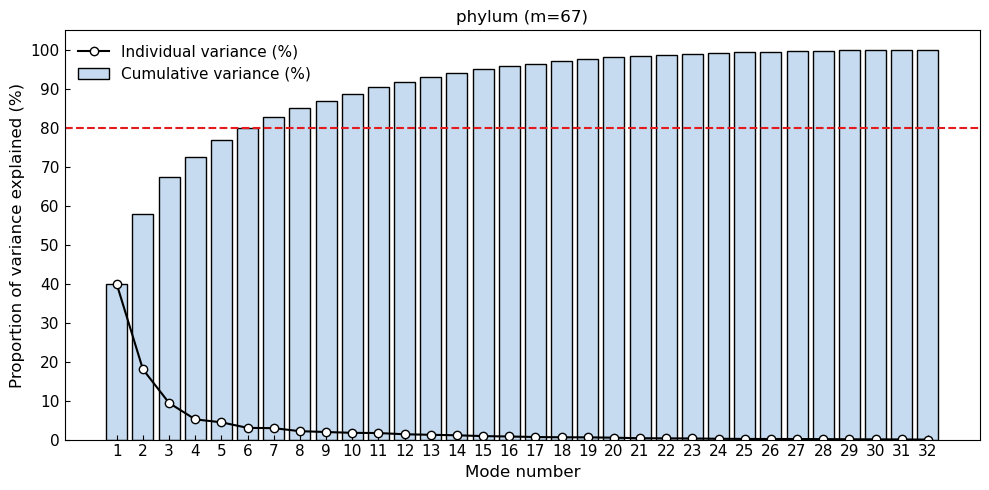

In [25]:
explained_var = 100 * fracVar_phylum                       
cumulative_var = 100 * np.cumsum(fracVar_phylum)            
pcs = np.arange(1, len(fracVar_phylum) + 1)                 

# Bar colors: first 8 darker, rest lighter
# bar_colors = ['#6baed6' if i < 8 else '#c6dbef' for i in range(len(pcs))]
bar_colors = ['#c6dbef']

fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot: cumulative variance (%)
ax.bar(pcs, cumulative_var, alpha=1, label='Cumulative variance (%)',
       color=bar_colors, edgecolor='black', linewidth=1)

# Line plot: individual variance (%)
ax.plot(pcs, explained_var, marker='o', color='k', mfc='white',
        label='Individual variance (%)')

# 90% threshold line
ax.axhline(y=80, color='#e41a1c', linestyle='--', linewidth=1.5)

# Axes/legend
ax.set_xlabel('Mode number', fontsize=12)
ax.set_ylabel('Proportion of variance explained (%)', fontsize=12)
ax.set_xticks(pcs)
ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(frameon=False, fontsize=11)
ax.set_title(f'phylum (m={eigvecs_phylum.shape[1]})')

# Style
ax.tick_params(axis='both', direction='in', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.show()


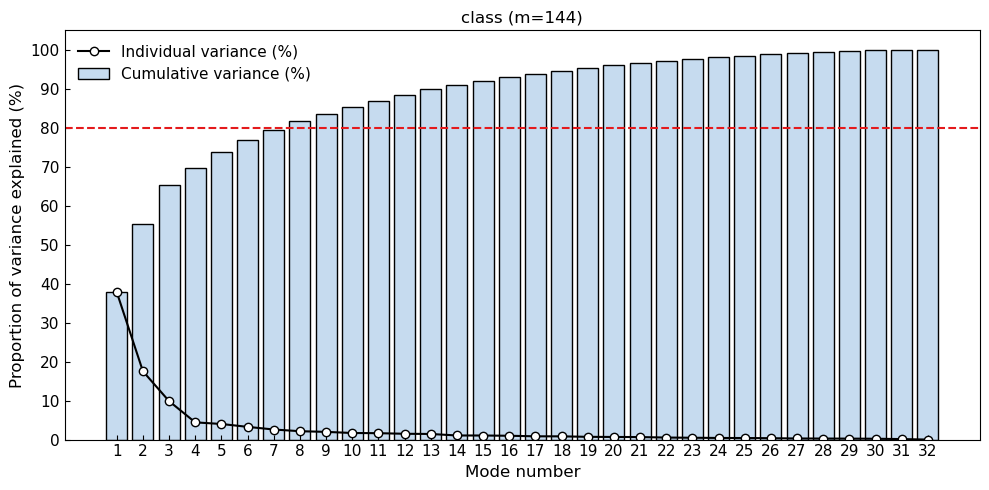

In [26]:
explained_var = 100 * fracVar_class                        
cumulative_var = 100 * np.cumsum(fracVar_class)            
pcs = np.arange(1, len(fracVar_class) + 1)                 

# Bar colors: first 8 darker, rest lighter
# bar_colors = ['#6baed6' if i < 8 else '#c6dbef' for i in range(len(pcs))]
bar_colors = ['#c6dbef']

fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot: cumulative variance (%)
ax.bar(pcs, cumulative_var, alpha=1, label='Cumulative variance (%)',
       color=bar_colors, edgecolor='black', linewidth=1)

# Line plot: individual variance (%)
ax.plot(pcs, explained_var, marker='o', color='k', mfc='white',
        label='Individual variance (%)')

# 90% threshold line
ax.axhline(y=80, color='#e41a1c', linestyle='--', linewidth=1.5)

# Axes/legend
ax.set_xlabel('Mode number', fontsize=12)
ax.set_ylabel('Proportion of variance explained (%)', fontsize=12)
ax.set_xticks(pcs)
ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(frameon=False, fontsize=11)
ax.set_title(f'class (m={eigvecs_class.shape[1]})')

# Style
ax.tick_params(axis='both', direction='in', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.show()

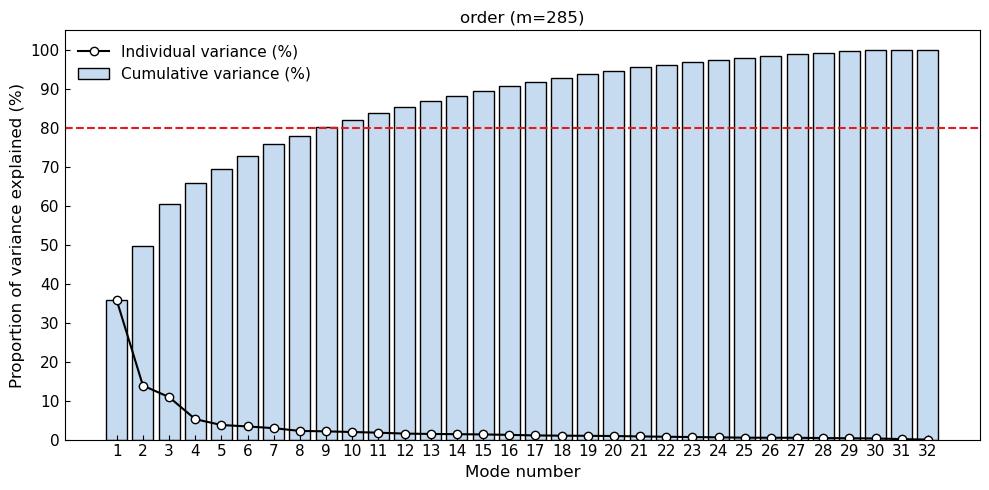

In [27]:
explained_var = 100 * fracVar_order                    
cumulative_var = 100 * np.cumsum(fracVar_order)            
pcs = np.arange(1, len(fracVar_order) + 1)                 

# Bar colors: first 8 darker, rest lighter
# bar_colors = ['#6baed6' if i < 8 else '#c6dbef' for i in range(len(pcs))]
bar_colors = ['#c6dbef']

fig, ax = plt.subplots(figsize=(10, 5))

# Bar plot: cumulative variance (%)
ax.bar(pcs, cumulative_var, alpha=1, label='Cumulative variance (%)',
       color=bar_colors, edgecolor='black', linewidth=1)

# Line plot: individual variance (%)
ax.plot(pcs, explained_var, marker='o', color='k', mfc='white',
        label='Individual variance (%)')

# 90% threshold line
ax.axhline(y=80, color='#e41a1c', linestyle='--', linewidth=1.5)

# Axes/legend
ax.set_xlabel('Mode number', fontsize=12)
ax.set_ylabel('Proportion of variance explained (%)', fontsize=12)
ax.set_xticks(pcs)
ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(frameon=False, fontsize=11)
ax.set_title(f'order (m={eigvecs_order.shape[1]})')

# Style
ax.tick_params(axis='both', direction='in', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.show()

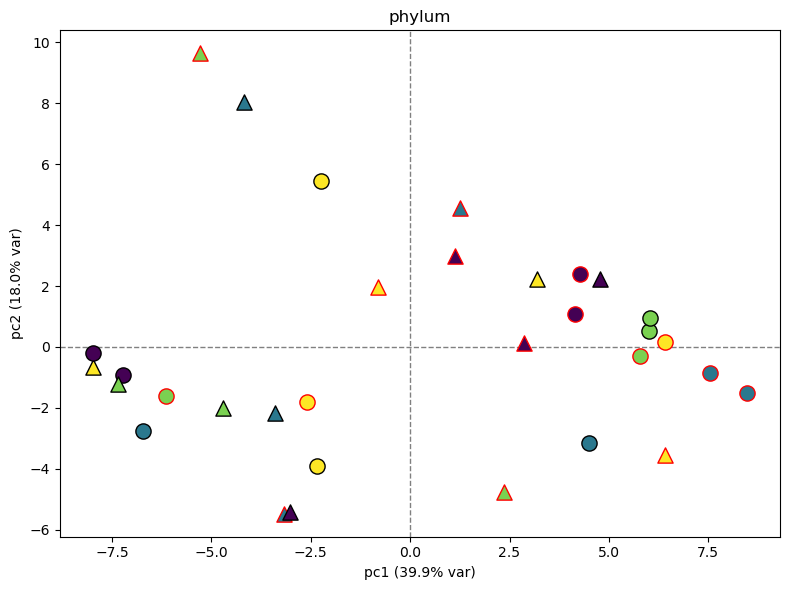

In [28]:
# define labels 
sample_labels = df_phylum['sample']
lake = df_phylum['Lake']
temp = df_phylum['Temp']
edge = df_phylum['Edge']

# define mappings 
lake_marker = {'Inre': 'o', 'Villa': '^'}
temp_color = {10: '#fde725', 15: '#7ad151', 20: '#2a788e', 25: '#440154'}
edge_border = {'Center': 'red', 'Edge': 'black'}

# plot 
plt.figure(figsize=(8, 6))
for i in range(len(df_phylum)):
    plt.scatter(
        PCs_phylum[i, 0],
        PCs_phylum[i, 1],
        s=120,
        marker=lake_marker.get(lake.iloc[i], 'o'),
        facecolor=temp_color.get(temp.iloc[i], 'gray'),
        edgecolor=edge_border.get(edge.iloc[i], 'black'),
        linewidth=1,
        zorder=3
    )

# axis labels 
plt.xlabel(f'pc1 ({fracVar_phylum[0]*100:.1f}% var)')
plt.ylabel(f'pc2 ({fracVar_phylum[1]*100:.1f}% var)')
plt.title('phylum')

plt.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
plt.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.show()

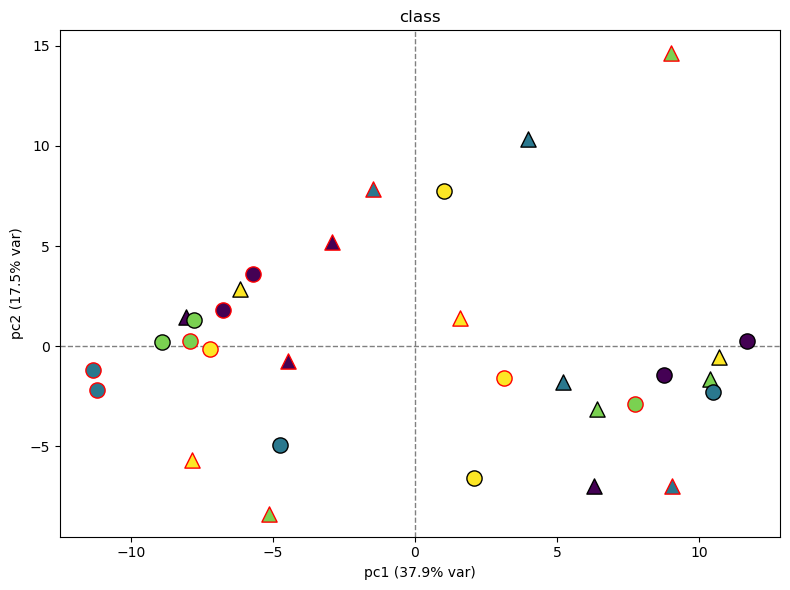

In [29]:
# define labels 
sample_labels = df_class['sample']
lake = df_class['Lake']
temp = df_class['Temp']
edge = df_class['Edge']

# define mappings 
lake_marker = {'Inre': 'o', 'Villa': '^'}
temp_color = {10: '#fde725', 15: '#7ad151', 20: '#2a788e', 25: '#440154'}
edge_border = {'Center': 'red', 'Edge': 'black'}

# plot 
plt.figure(figsize=(8, 6))
for i in range(len(df_class)):
    plt.scatter(
        PCs_class[i, 0],
        PCs_class[i, 1],
        s=120,
        marker=lake_marker.get(lake.iloc[i], 'o'),
        facecolor=temp_color.get(temp.iloc[i], 'gray'),
        edgecolor=edge_border.get(edge.iloc[i], 'black'),
        linewidth=1,
        zorder=3
    )

# axis labels 
plt.xlabel(f'pc1 ({fracVar_class[0]*100:.1f}% var)')
plt.ylabel(f'pc2 ({fracVar_class[1]*100:.1f}% var)')
plt.title('class')

plt.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
plt.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.show()

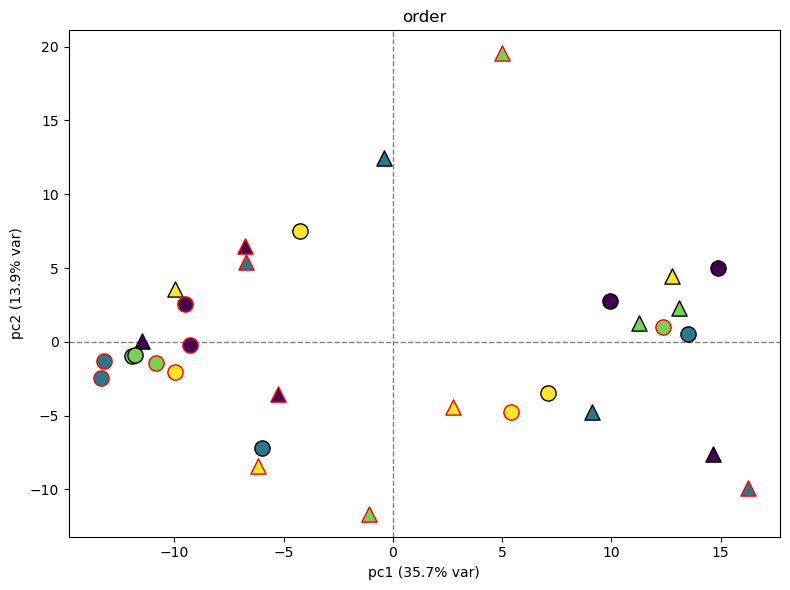

In [30]:
# define labels 
sample_labels = df_order['sample']
lake = df_order['Lake']
temp = df_order['Temp']
edge = df_order['Edge']

# define mappings 
lake_marker = {'Inre': 'o', 'Villa': '^'}
temp_color = {10: '#fde725', 15: '#7ad151', 20: '#2a788e', 25: '#440154'}
edge_border = {'Center': 'red', 'Edge': 'black'}

# plot 
plt.figure(figsize=(8, 6))
for i in range(len(df_order)):
    plt.scatter(
        PCs_order[i, 0],
        PCs_order[i, 1],
        s=120,
        marker=lake_marker.get(lake.iloc[i], 'o'),
        facecolor=temp_color.get(temp.iloc[i], 'gray'),
        edgecolor=edge_border.get(edge.iloc[i], 'black'),
        linewidth=1,
        zorder=3
    )

# axis labels 
plt.xlabel(f'pc1 ({fracVar_order[0]*100:.1f}% var)')
plt.ylabel(f'pc2 ({fracVar_order[1]*100:.1f}% var)')
plt.title('order')

plt.axhline(0, color='gray', linewidth=1, linestyle='--', zorder=1)
plt.axvline(0, color='gray', linewidth=1, linestyle='--', zorder=1)

plt.tight_layout()
plt.show()

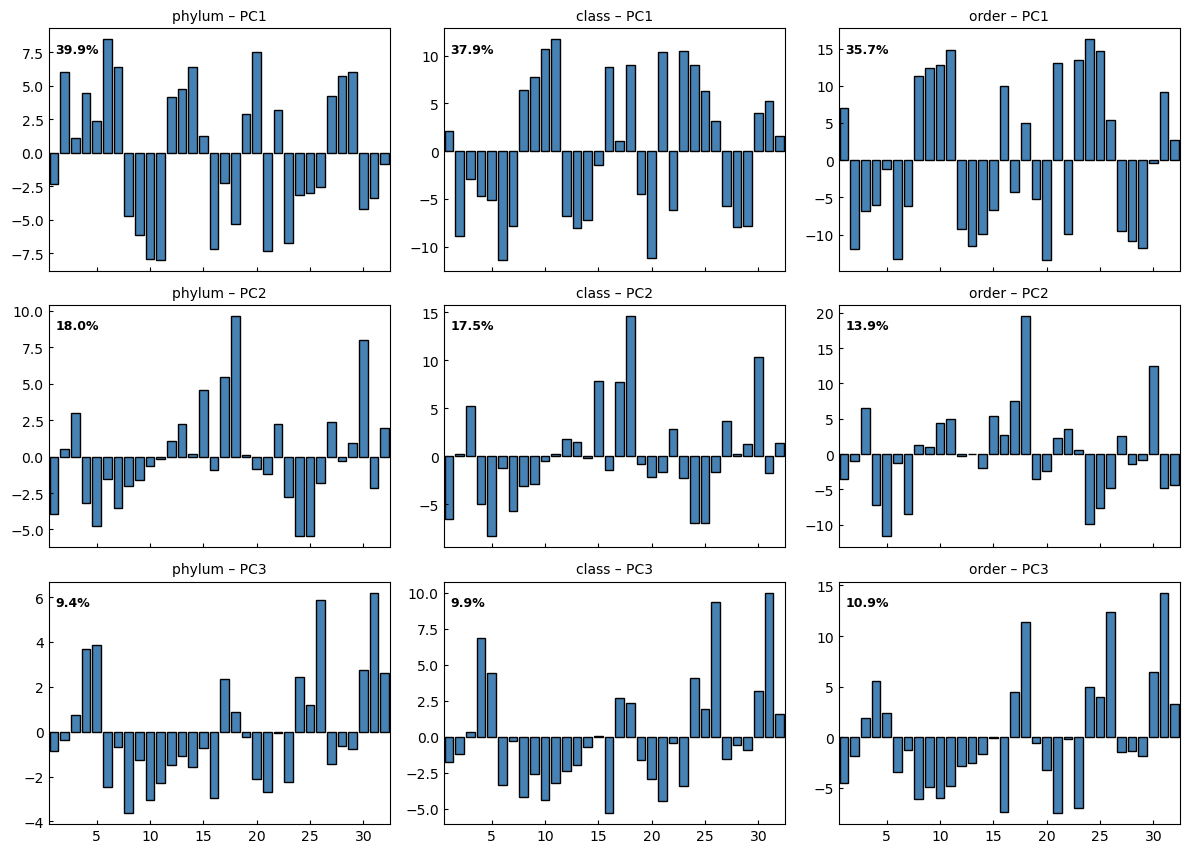

In [31]:
# Define names and data to iterate easily
datasets = [
    ('phylum', PCs_phylum, fracVar_phylum),
    ('class',  PCs_class,  fracVar_class),
    ('order',  PCs_order,  fracVar_order)
]

fig, axes = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
for row in range(3):  # pc1-3 
    for col, (name, PCs, fracVar) in enumerate(datasets):
        ax = axes[row, col]
        ax.bar(np.arange(1, 33), PCs[:, row], color='steelblue', edgecolor='k')
        ax.set_title(f'{name} – PC{row+1}', fontsize=10)
        ax.tick_params(axis='x', direction='in', length=3)
        ax.tick_params(axis='y', direction='in', length=3)
        ax.set_xlim(0.5, 32.5)
        ax.text(0.02, 0.9, f'{fracVar[row]*100:.1f}%', transform=ax.transAxes, fontsize=9, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()